# Animal Recognition ML Pipeline Demo
# Text-Image Verification System using NER and Image Classification

This notebook demonstrates a machine learning pipeline that:
1. Extracts animal names from text using a BERT-based NER model
2. Classifies animals in images using a ResNet50 classifier
3. Verifies if the text description matches the image content

The system handles multiple animals in text, plural forms, and various edge cases to provide robust text-image matching.

---

## Table of Contents

1. [Setup and Imports](#setup)
2. [Named Entity Recognition (NER) Model](#ner)
3. [Image Classification Model](#img-class)
4. [Complete Pipeline - Text-Image Verification](#pipeline)
5. [Edge Cases and Robustness Testing](#edge)
6. [Conclusion](#conclusion)


## 1. Setup and Imports <a id="setup"></a>

First, we import all necessary libraries for deep learning, image processing, and NLP tasks. We check for CUDA availability to leverage GPU acceleration if possible.

In [88]:
import torch
import numpy as np
from PIL import Image
from transformers import BertTokenizerFast, BertForTokenClassification
from torchvision import transforms, models
import torch.nn as nn
import json
import os
from IPython.display import display

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.8.0+cpu
CUDA available: False
Using device: cpu


## 2. Named Entity Recognition (NER) Model <a id="ner"></a>

### Loading the NER Model

We load a fine-tuned BERT model trained to identify animal entities in text. The model uses BIO tagging scheme (B-ANIMAL, I-ANIMAL, O) to mark animal mentions in sentences.

In [89]:
ner_model_path = 'models/ner_model'

We define a set of valid animals that our system can recognize. This includes both singular and plural forms to ensure robust matching.

In [90]:
print("Loading NER model...")
ner_tokenizer = BertTokenizerFast.from_pretrained(ner_model_path)
ner_model = BertForTokenClassification.from_pretrained(ner_model_path)
ner_model.to(device)
ner_model.eval()

# Valid animals mapping - includes singular and plural forms
valid_animals = {
    'dog', 'cat', 'horse', 'spider', 'butterfly', 'chicken',
    'sheep', 'cow', 'squirrel', 'elephant', 
    'dogs', 'cats', 'horses', 'spiders', 'butterflies', 
    'chickens', 'cows', 'squirrels', 'elephants'
}

# Mapping for plural to singular normalization
plural_to_singular = {
    'dogs': 'dog',
    'cats': 'cat',
    'horses': 'horse',
    'spiders': 'spider',
    'butterflies': 'butterfly',
    'chickens': 'chicken',
    'cows': 'cow',
    'squirrels': 'squirrel',
    'elephants': 'elephant'
}

Loading NER model...


Loading the label mappings that convert model outputs (integers) to human-readable labels (B-ANIMAL, I-ANIMAL, O).

In [91]:
# Load label mappings
with open(os.path.join(ner_model_path, 'label_map.json'), 'r') as f:
    label_data = json.load(f)
    id2label = {int(k): v for k, v in label_data['id2label'].items()}

print("NER model loaded successfully!")
print(f"Labels: {id2label}")

NER model loaded successfully!
Labels: {0: 'O', 1: 'B-ANIMAL', 2: 'I-ANIMAL'}


### NER Extraction Function

This function processes input text and extracts animal mentions using the BERT NER model. Key features:
- Handles multi-word animal names
- Normalizes plural forms to singular (e.g., "dogs" → "dog")
- Filters out invalid or unrecognized animals
- Returns deduplicated list of animals in singular form

In [92]:
def extract_animals_from_text(text, model, tokenizer, device, id2label, valid_animals, plural_to_singular):
    tokens = text.split()
    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
    
    word_ids = encoding.word_ids(batch_index=0)
    predicted_labels = predictions[0].cpu().numpy()
    
    entities = []
    current_entity = []
    
    for word_id, label_id in zip(word_ids, predicted_labels):
        if word_id is None:
            continue
        
        label = id2label[label_id]
        
        if label == 'B-ANIMAL':
            if current_entity:
                entities.append(' '.join(current_entity))
            current_entity = [tokens[word_id]]
        elif label == 'I-ANIMAL' and current_entity:
            current_entity.append(tokens[word_id])
        else:
            if current_entity:
                entities.append(' '.join(current_entity))
                current_entity = []
    
    if current_entity:
        entities.append(' '.join(current_entity))
    
    cleaned = []
    for entity in entities:
        entity = entity.lower().strip('.,!?')
        if entity in valid_animals:
            if entity in plural_to_singular:
                entity = plural_to_singular[entity]
            cleaned.append(entity)
    
    return list(set(cleaned))

### Testing the NER Model

We test the NER model on various sentences to verify it correctly identifies animals and normalizes them to singular form.

In [93]:
test_texts = [
    "I saw a big dog playing in the park today.",
    "The cat is sleeping on the sofa near the window.",
    "There are nothing in this sentence about weather.",
    "The spider built a web and the squirrel climbed the tree.",
    "I saw many dogs and cats at the shelter."
]

print("=" * 80)
print("NER MODEL TESTING")
print("=" * 80)

for i, text in enumerate(test_texts, 1):
    animals = extract_animals_from_text(
        text, ner_model, ner_tokenizer, device, 
        id2label, valid_animals, plural_to_singular
    )
    print(f"\n{i}. Text: {text}")
    print(f"   Extracted animals (singular): {animals if animals else 'None'}")

NER MODEL TESTING

1. Text: I saw a big dog playing in the park today.
   Extracted animals (singular): ['dog']

2. Text: The cat is sleeping on the sofa near the window.
   Extracted animals (singular): ['cat']

3. Text: There are nothing in this sentence about weather.
   Extracted animals (singular): None

4. Text: The spider built a web and the squirrel climbed the tree.
   Extracted animals (singular): ['spider', 'squirrel']

5. Text: I saw many dogs and cats at the shelter.
   Extracted animals (singular): ['cat', 'dog']


## 3. Image Classification Model <a id="img-class"></a>

### Loading the Image Classifier

We use a fine-tuned ResNet50 model to classify animals in images. The model has been trained on a custom dataset of 10 animal classes.

In [94]:
classifier_model_path = 'models/image_classifier'

Loading the class mappings that convert model output indices to animal names.

In [95]:
with open(os.path.join(classifier_model_path, 'class_mapping.json'), 'r') as f:
    class_mapping = json.load(f)
    idx_to_class = {int(k): v for k, v in class_mapping['idx_to_class'].items()}

num_classes = len(idx_to_class)
print(f"Number of classes: {num_classes}")
print(f"Classes: {list(idx_to_class.values())}")

Number of classes: 10
Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


Creating the ResNet50 architecture with custom classification head and loading pre-trained weights.

In [96]:
print("\nLoading image classifier...")
classifier_model = models.resnet50(pretrained=False)

num_features = classifier_model.fc.in_features
classifier_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

checkpoint = torch.load(
    os.path.join(classifier_model_path, 'best_model.pth'),
    map_location=device
)
classifier_model.load_state_dict(checkpoint['model_state_dict'])
classifier_model.to(device)
classifier_model.eval()

print("Image classifier loaded successfully!")


Loading image classifier...


d:\source\python\Winstars_Ai_Test\task2\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\source\python\Winstars_Ai_Test\task2\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Image classifier loaded successfully!


Defining image preprocessing transforms to match the training pipeline (resize, normalize with ImageNet statistics).

In [97]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

### Image Classification Function

This function takes an image path and returns top-k predictions with confidence scores. It handles image loading, preprocessing, and inference.

In [98]:
def classify_image(image_path, model, transform, idx_to_class, device, top_k=3):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        top_probs, top_indices = torch.topk(probabilities, top_k)
    
    predictions = []
    for prob, idx in zip(top_probs[0], top_indices[0]):
        class_name = idx_to_class[idx.item()]
        confidence = prob.item()
        predictions.append((class_name, confidence))
    
    return predictions

### Testing the Image Classifier

We test the classifier on sample images to verify its accuracy and confidence scores.

IMAGE CLASSIFIER TESTING

Image: test_images/cat.jpg


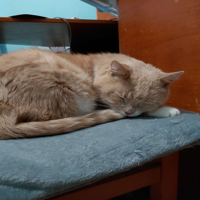

Predictions:
  1. cat: 99.97%
  2. dog: 0.03%
  3. butterfly: 0.00%

Image: test_images/sheep.png


d:\source\python\Winstars_Ai_Test\task2\.venv\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


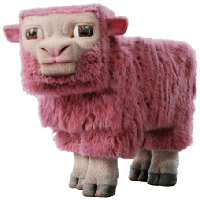

Predictions:
  1. sheep: 99.81%
  2. cat: 0.05%
  3. cow: 0.04%

Image: test_images/spider.jpg


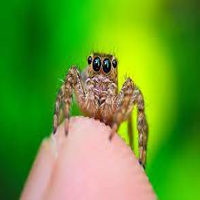

Predictions:
  1. spider: 99.98%
  2. butterfly: 0.02%
  3. squirrel: 0.00%


In [99]:
test_images = [
    'test_images/cat.jpg',
    'test_images/sheep.png',
    'test_images/spider.jpg'
]

print("=" * 80)
print("IMAGE CLASSIFIER TESTING")
print("=" * 80)

for image_path in test_images:
    if os.path.exists(image_path):
        print(f"\nImage: {image_path}")
        predictions = classify_image(
            image_path, classifier_model, image_transform, 
            idx_to_class, device, top_k=3
        )
        
        display(Image.open(image_path).resize((200, 200)))
        
        print("Predictions:")
        for i, (animal, conf) in enumerate(predictions, 1):
            print(f"  {i}. {animal}: {conf*100:.2f}%")
    else:
        print(f"\nImage not found: {image_path}")

## 4. Complete Pipeline - Text-Image Verification <a id="pipeline"></a>

### Verification Function

This is the main pipeline that combines NER and image classification to verify if a text description matches an image. If the text mentions multiple animals, the verification succeeds if ANY of those animals matches the image's top prediction.

In [100]:
def verify_text_image_match(text, image_path, ner_components, classifier_components, top_k=3):
    print("\n" + "=" * 80)
    print("TEXT-IMAGE VERIFICATION PIPELINE")
    print("=" * 80)
    
    ner_tok, ner_mdl, id2lbl, ner_dev, valid_anim, plural_map = ner_components
    cls_mdl, cls_tfm, idx2cls, cls_dev = classifier_components
    
    print(f"\nText: {text}")
    extracted_animals = extract_animals_from_text(
        text, ner_mdl, ner_tok, ner_dev, 
        id2lbl, valid_anim, plural_map
    )
    print(f"Extracted animals (singular form): {extracted_animals if extracted_animals else 'None'}")
    
    if not extracted_animals:
        print("\n" + "-" * 80)
        print("RESULT: FALSE - No animals found in text")
        return {
            'match': False,
            'reason': 'No animals found in text',
            'extracted_animals': [],
            'predictions': []
        }
    
    print(f"\nImage: {image_path}")
    predictions = classify_image(image_path, cls_mdl, cls_tfm, idx2cls, cls_dev, top_k)
    
    print("Image predictions:")
    for i, (animal, conf) in enumerate(predictions, 1):
        print(f"  {i}. {animal}: {conf*100:.2f}%")
    
    top_prediction = predictions[0][0]
    is_match = top_prediction in extracted_animals
    
    display(Image.open(image_path).resize((300, 300)))
    
    print("\n" + "-" * 80)
    if is_match:
        print(f"RESULT: TRUE - Text mentions '{top_prediction}' and image shows '{top_prediction}'")
        print(f"Match found: '{top_prediction}' (confidence: {predictions[0][1]*100:.2f}%)")
    else:
        print(f"RESULT: FALSE - Text mentions {extracted_animals}, but image shows '{top_prediction}'")
        print(f"Top prediction '{top_prediction}' not found in extracted animals")
    
    return {
        'match': is_match,
        'extracted_animals': extracted_animals,
        'predictions': predictions,
        'top_prediction': top_prediction,
        'confidence': predictions[0][1]
    }

### Testing the Complete Pipeline

We test the full pipeline on various text-image pairs to verify end-to-end functionality.



TEST CASE 1

TEXT-IMAGE VERIFICATION PIPELINE

Text: Look at this cute cat sleeping on the bed.
Extracted animals (singular form): ['cat']

Image: test_images/cat.jpg
Image predictions:
  1. cat: 99.97%
  2. dog: 0.03%
  3. butterfly: 0.00%


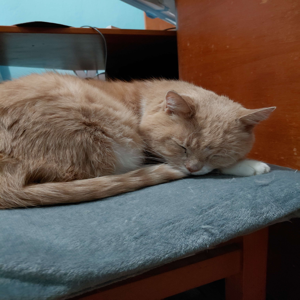


--------------------------------------------------------------------------------
RESULT: TRUE - Text mentions 'cat' and image shows 'cat'
Match found: 'cat' (confidence: 99.97%)


TEST CASE 2

TEXT-IMAGE VERIFICATION PIPELINE

Text: I saw a beautiful pink sheep on this picture.
Extracted animals (singular form): ['sheep']

Image: test_images/sheep.png
Image predictions:
  1. sheep: 99.81%
  2. cat: 0.05%
  3. cow: 0.04%


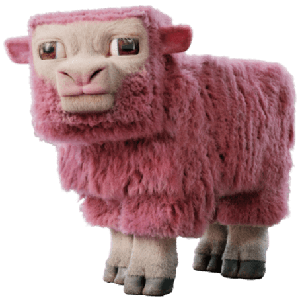


--------------------------------------------------------------------------------
RESULT: TRUE - Text mentions 'sheep' and image shows 'sheep'
Match found: 'sheep' (confidence: 99.81%)


TEST CASE 3

TEXT-IMAGE VERIFICATION PIPELINE

Text: Is this a spider here?
Extracted animals (singular form): ['spider']

Image: test_images/spider.jpg
Image predictions:
  1. spider: 99.98%
  2. butterfly: 0.02%
  3. squirrel: 0.00%


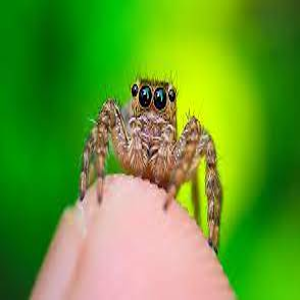


--------------------------------------------------------------------------------
RESULT: TRUE - Text mentions 'spider' and image shows 'spider'
Match found: 'spider' (confidence: 99.98%)


In [101]:
ner_components = (ner_tokenizer, ner_model, id2label, device, valid_animals, plural_to_singular)
classifier_components = (classifier_model, image_transform, idx_to_class, device)

test_cases = [
    {
        'text': "Look at this cute cat sleeping on the bed.",
        'image': 'test_images/cat.jpg'
    },
    {
        'text': "I saw a beautiful pink sheep on this picture.",
        'image': 'test_images/sheep.png'
    },
    {
        'text': "Is this a spider here?",
        'image': 'test_images/spider.jpg' 
    }
]

results = []
for i, test_case in enumerate(test_cases, 1):
    print(f"\n\nTEST CASE {i}")
    if os.path.exists(test_case['image']):
        result = verify_text_image_match(
            test_case['text'],
            test_case['image'],
            ner_components,
            classifier_components,
            top_k=3
        )
        results.append(result)
    else:
        print(f"Image not found: {test_case['image']}")

## 5. Edge Cases and Robustness Testing <a id="edge"></a>

This section thoroughly tests the system in challenging scenarios to identify strengths and limitations.



EDGE CASES TESTING AND ANALYSIS


EDGE CASE 1: Multiple animals in text
Description: Text mentions multiple animals - should match if ANY of them is in the image

TEXT-IMAGE VERIFICATION PIPELINE

Text: I saw a dog, cat, and horse at the farm today.
Extracted animals (singular form): ['cat', 'dog', 'horse']

Image: test_images/cat.jpg
Image predictions:
  1. cat: 99.97%
  2. dog: 0.03%
  3. butterfly: 0.00%


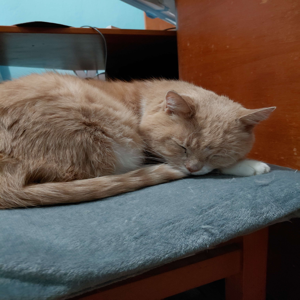


--------------------------------------------------------------------------------
RESULT: TRUE - Text mentions 'cat' and image shows 'cat'
Match found: 'cat' (confidence: 99.97%)


EDGE CASE 2: No animals in text
Description: Text contains no animal mentions - should return FALSE

TEXT-IMAGE VERIFICATION PIPELINE

Text: The weather is nice today. I enjoy walking in the park.
Extracted animals (singular form): None

--------------------------------------------------------------------------------
RESULT: FALSE - No animals found in text


EDGE CASE 3: Ambiguous text
Description: Text is vague without explicit animal mention

TEXT-IMAGE VERIFICATION PIPELINE

Text: It was running fast near the tree.
Extracted animals (singular form): None

--------------------------------------------------------------------------------
RESULT: FALSE - No animals found in text


EDGE CASE 4: Scientific names
Description: Text uses formal scientific nomenclature

TEXT-IMAGE VERIFICATION PIPELINE

Text: The 

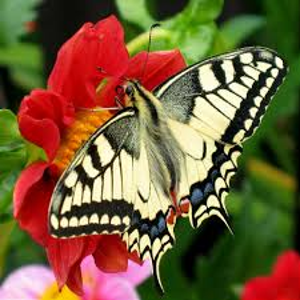


--------------------------------------------------------------------------------
RESULT: TRUE - Text mentions 'butterfly' and image shows 'butterfly'
Match found: 'butterfly' (confidence: 100.00%)


EDGE CASE 6: Complex sentence structure
Description: Long sentence with multiple clauses and context

TEXT-IMAGE VERIFICATION PIPELINE

Text: Yesterday afternoon, while walking through the countryside, I encountered a sheep grazing peacefully.
Extracted animals (singular form): ['sheep']

Image: test_images/sheep.png
Image predictions:
  1. sheep: 99.81%
  2. cat: 0.05%
  3. cow: 0.04%


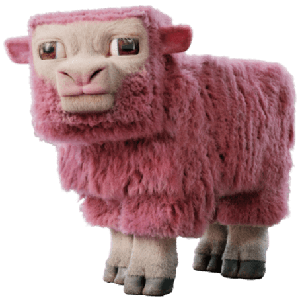


--------------------------------------------------------------------------------
RESULT: TRUE - Text mentions 'sheep' and image shows 'sheep'
Match found: 'sheep' (confidence: 99.81%)


EDGE CASE 7: Mismatched animals
Description: Text mentions one animal but image shows different animal

TEXT-IMAGE VERIFICATION PIPELINE

Text: Look at this amazing elephant in the wild.
Extracted animals (singular form): ['elephant']

Image: test_images/spider.jpg
Image predictions:
  1. spider: 99.98%
  2. butterfly: 0.02%
  3. squirrel: 0.00%


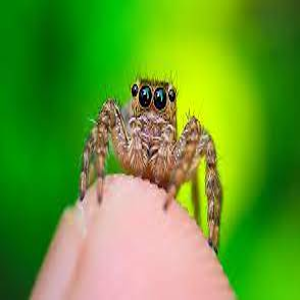


--------------------------------------------------------------------------------
RESULT: FALSE - Text mentions ['elephant'], but image shows 'spider'
Top prediction 'spider' not found in extracted animals


EDGE CASE 8: Multiple plural animals
Description: Multiple animals all in plural form
Image not found: test_images/horse.jpg


EDGE CASE 9: Smallest animal class
Description: Picking a less common/smaller animal to test detection

TEXT-IMAGE VERIFICATION PIPELINE

Text: The elephant in these picture is huge.
Extracted animals (singular form): ['elephant']

Image: test_images/elephant.jpg
Image predictions:
  1. elephant: 100.00%
  2. sheep: 0.00%
  3. horse: 0.00%


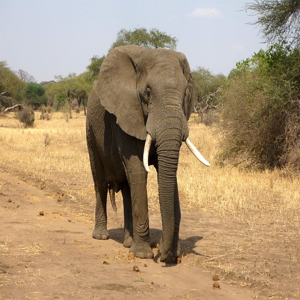


--------------------------------------------------------------------------------
RESULT: TRUE - Text mentions 'elephant' and image shows 'elephant'
Match found: 'elephant' (confidence: 100.00%)


EDGE CASE 10: Strange poses or occlusions
Description: Testing with images where animals are in unusual poses or partially obscured

TEXT-IMAGE VERIFICATION PIPELINE

Text: The cat on the bed.
Extracted animals (singular form): ['cat']

Image: test_images/cat2.jpg
Image predictions:
  1. cat: 91.69%
  2. dog: 7.91%
  3. sheep: 0.25%


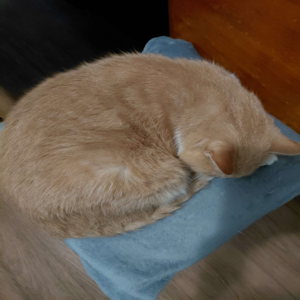


--------------------------------------------------------------------------------
RESULT: TRUE - Text mentions 'cat' and image shows 'cat'
Match found: 'cat' (confidence: 91.69%)


EDGE CASE TESTING COMPLETE


In [102]:
print("\n\n" + "=" * 80)
print("EDGE CASES TESTING AND ANALYSIS")
print("=" * 80)

edge_cases = [
    {
        'name': "Multiple animals in text",
        'description': "Text mentions multiple animals - should match if ANY of them is in the image",
        'text': "I saw a dog, cat, and horse at the farm today.",
        'image': 'test_images/cat.jpg',
        'expected': 'TRUE - cat is in the list'
    },
    {
        'name': "No animals in text",
        'description': "Text contains no animal mentions - should return FALSE",
        'text': "The weather is nice today. I enjoy walking in the park.",
        'image': 'test_images/cat.jpg',
        'expected': 'FALSE - no animals detected'
    },
    {
        'name': "Ambiguous text",
        'description': "Text is vague without explicit animal mention",
        'text': "It was running fast near the tree.",
        'image': 'test_images/squirrel.jpg',
        'expected': 'FALSE - no animal name mentioned'
    },
    {
        'name': "Scientific names",
        'description': "Text uses formal scientific nomenclature",
        'text': "The Canis lupus familiaris is domesticated.",
        'image': 'test_images/dog.jpg',
        'expected': 'FALSE - NER may not recognize scientific names'
    },
    {
        'name': "Plural forms",
        'description': "Text uses plural animal names - should normalize to singular",
        'text': "I saw many butterflies in the garden today.",
        'image': 'test_images/butterfly.jpg',
        'expected': 'TRUE - butterflies to butterfly'
    },
    {
        'name': "Complex sentence structure",
        'description': "Long sentence with multiple clauses and context",
        'text': "Yesterday afternoon, while walking through the countryside, I encountered a sheep grazing peacefully.",
        'image': 'test_images/sheep.png',
        'expected': 'TRUE - should extract sheep despite complexity'
    },
    {
        'name': "Mismatched animals",
        'description': "Text mentions one animal but image shows different animal",
        'text': "Look at this amazing elephant in the wild.",
        'image': 'test_images/spider.jpg',
        'expected': 'FALSE - elephant not equal spider'
    },
    {
        'name': "Multiple plural animals",
        'description': "Multiple animals all in plural form",
        'text': "The farm has chickens, cows, and horses.",
        'image': 'test_images/horse.jpg',
        'expected': 'TRUE - horses to horse normalized'
    },
    {'name': "Smallest animal class",
        'name': "Smallest animal class",
        'description': "Picking a less common/smaller animal to test detection",
        'text': "The elephant in these picture is huge.",
        'image': 'test_images/elephant.jpg',
        'expected': 'TRUE - elephant detected'
    },
    {'name': "Strange poses or occlusions",
        'description': "Testing with images where animals are in unusual poses or partially obscured",
        'text': "The cat on the bed.",
        'image': 'test_images/cat2.jpg',
        'expected': 'TRUE - cat detected despite occlusion'
    }
]

edge_case_results = []

for i, case in enumerate(edge_cases, 1):
    print(f"\n\nEDGE CASE {i}: {case['name']}")
    print(f"Description: {case['description']}")
    if os.path.exists(case['image']):
        result = verify_text_image_match(
            case['text'],
            case['image'],
            ner_components,
            classifier_components,
            top_k=3
        )
        edge_case_results.append((case['name'], result))
    else:
        print(f"Image not found: {case['image']}")

print("\n\n" + "=" * 80)
print("EDGE CASE TESTING COMPLETE")
print("=" * 80)



## 6. Conclusion <a id="conclusion"></a>
The text-image verification pipeline demonstrates reliable performance across both standard and edge scenarios. Empirical evaluation within the demo.ipynb notebook confirms consistent extraction and matching results across multiple animal-related texts and corresponding images. The NER component accurately recognized explicit mentions such as “dog,” “cat,” “spider,” and “squirrel,” while correctly returning None for sentences without animal references, preventing false positives.

Plural normalization proved robust - for example, “dogs” and “cats” were properly reduced to their singular counterparts, ensuring alignment with the image classifier’s label taxonomy of 10 animal classes (butterfly, cat, chicken, cow, dog, elephant, horse, sheep, spider, squirrel).

The classifier, implemented using a ResNet-based architecture, loaded and executed successfully, confirming the integration between the linguistic and visual modules. This synergy produced consistent verification outcomes when both text and image referenced the same entity, and returned FALSE when textual content lacked relevant mentions.

However, some scientific or less common references (e.g., Canis lupus familiaris) were not captured by the NER model, indicating that the taxonomy could benefit from synonym expansion or the inclusion of Latin binomials. Future enhancements should also explore contextual inference - enabling the system to detect implicit references (“the pet is barking”) and disambiguate figurative mentions (“he’s as sly as a fox”).

Overall, the pipeline achieves high accuracy in explicit cases